# Fine tune a checkpoint of MedSAM on point prompted Data

Given a path to a MedSAM checkpoint, we want to fine tune it on pre-processed data
(subject to modifications specified by the paper and the transformation script). This will
be done initially on an anatomy-specific level.

## Argparse Setup

In [1]:
# Imports
import re
import os
import cv2
import sys
import json
import torch
import monai
import random
import argparse
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from time import time, sleep
from datetime import datetime
from skimage import transform
from matplotlib import pyplot as plt
from segment_anything import sam_model_registry
from torch.utils.data import Dataset, DataLoader

# Add the setup_data_vars function as we will need it to find the directory for the training data.
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars
setup_data_vars()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
anatomy = 'Bladder'
lowres = True
model_path = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres', anatomy, 'checkpoint_best.pth')
data_split = os.path.join(os.environ.get('MedSAM_finetuned'), 'boxed_lowres', anatomy, 'data_splits.json')
img_data = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'imgs')
gt_data = os.path.join(os.environ.get('MedSAM_preprocessed_lowres'), 'gts', anatomy)

assert os.path.exists(model_path), f"Model path {model_path} does not exist."
assert os.path.exists(data_split), f"Data split {data_split} does not exist."
assert os.path.exists(img_data), f"Raw data {img_data} does not exist."
assert os.path.exists(gt_data), f"Ground truth data {gt_data} does not exist."

In [3]:
image_id_from_file_name_regex = r'.*_(\d+).*'
slice_id_from_file_name_regex = r'.*-(\d+).*'

## Set up Dataset class

In [4]:
# read in the validation_image_ids
with open(data_split, 'r') as f:
    data = json.load(f)
    validation_image_ids = data['validation_image_ids']

validation_image_ids

[2, 10, 11, 16, 38, 42, 43, 46, 49, 51, 56, 57, 66, 71, 73, 74, 77, 79, 92, 93]

In [5]:
from stocaching import SharedCache

# Adapted Dataset class from ../2_no_finetuning/MEDSAM_helper_functions.py
class SAM_Dataset(Dataset):
    """A torch dataset for delivering slices of any axis to a medsam model."""

    def __init__(self, img_path, gt_path, id_split, data_aug=False, max_points=5, box_padding=10, max_box_points=3):
        """
        Args:
            img_path (string): Path to the directory containing the images
            gt_path (string): Path to the directory containing the ground truth masks
            id_split (list): List of image ids to include in the dataset
        """

        self.root_img_path = img_path
        self.root_gt_path = gt_path
        self.id_split = id_split
        self.data_aug = data_aug
        self.max_points = max_points
        self.box_padding = box_padding
        self.max_box_points = max_box_points
        
        # Assume that axese 0 1 and 2 have been processed.
        filter_fn = lambda x : x.endswith('.npy') and int(re.search(image_id_from_file_name_regex, x).group(1)) in id_split
        self.axis0_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis0'))))
        self.axis1_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis1'))))
        self.axis2_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis2'))))

        self.cache = SharedCache(
            size_limit_gib=20,
            dataset_len=self.__len__(),
            # dataset_len = self.__len__() if batches_per_epoch is None else min(self.__len__(), batches_per_epoch),
            data_dims=(512,512),
            dtype=torch.float32
        )

    def __len__(self):
        return len(self.axis0_imgs) + len(self.axis1_imgs) + len(self.axis2_imgs)

    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        # Fetch the image and ground truth mask. For safety, we index the items around the
        # ground truth masks, so that if for some reason the images are misaligned we will
        # guarantee that we will fetch the correct image

        img_path, gt_path, img_name, axis = self._get_image_and_gt_path(idx)

        img = self._load_image(img_path, idx, axis) # (H, W, C)
        gt = self._load_gt(gt_path, axis) # (H, W, C)

        # add data augmentation: random fliplr and random flipud
        if self.data_aug:
            if random.random() > 0.5:
                # img = np.ascontiguousarray(np.flip(img, axis=-1))
                gt = np.ascontiguousarray(np.flip(gt, axis=-1))
                img = img.flip(-1).contiguous()
                # gt = gt.flip(-1).contiguous()
            if random.random() > 0.5:
                # img = np.ascontiguousarray(np.flip(img, axis=-2))
                gt = np.ascontiguousarray(np.flip(gt, axis=-2))
                img = img.flip(-2).contiguous()
                # gt = gt.flip(-2).contiguous()
        
        coords = self._get_random_coord(gt) if self.max_points > 0 else np.ones((0, 2)) * -1
        boxes, gt = self._get_bounding_boxes(gt) if self.max_box_points > 0 else (np.ones((0, 4)) * -1, gt)

        # The output of the model is 256x256, and it is easier to reason about
        # constricting an image, rather than expanding the output back ot 1024x1024

        gt = cv2.resize(
            gt,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
        )

        return {
            "image": img, # 3x1024x1024
            "gt2D": torch.tensor(gt[None, :,:]).long(), # 1x256x256
            "coords": torch.tensor(coords[None, ...]).float(),
            "boxes": torch.tensor(boxes[None, ...]).float(),
            "image_name": img_name
        }
    
    def _get_image_and_gt_path(self, idx):
        if idx < len(self.axis0_imgs):
            axis, gt_name = 0, self.axis0_imgs[idx]
        elif idx < len(self.axis0_imgs) + len(self.axis1_imgs):
            axis, gt_name = 1, self.axis1_imgs[idx - len(self.axis0_imgs)]
        else:
            axis, gt_name = 2, self.axis2_imgs[idx - len(self.axis0_imgs) - len(self.axis1_imgs)]

        image_id = int(re.search(image_id_from_file_name_regex, gt_name).group(1))
        slice_id = int(re.search(slice_id_from_file_name_regex, gt_name).group(1))

        img_name = f'CT_zzAMLART_{image_id:03d}-{slice_id:03d}.npy'
        
        img_path = os.path.join(self.root_img_path, f'axis{axis}', img_name)
        gt_path = os.path.join(self.root_gt_path, f'axis{axis}', gt_name)

        return img_path, gt_path, img_name, axis
    
    def _get_random_coord(self, gt):
        # Select a random point. We will use this point to guide the model to segment the
        # anatomy. The idea is that we want to select the center of this shape with
        # greater probability than the outside of the shape.

        gt = np.uint8(gt > 0)
        y_indices, x_indices = np.where(gt > 0)

        # decide how many samples to draw from the segmentation area
        area = len(x_indices)
        # 1000 => 1
        # 5000 => 2
        # 10000 => 3
        # 15000 => 4
        n_samples = min(self.max_points, 1 + area // 5000)

        # Calculate the centroid of the segmentation
        centroid_x = np.mean(x_indices)
        centroid_y = np.mean(y_indices)

        # Calculate distances of each point from the centroid
        distances = np.sqrt((x_indices - centroid_x)**2 + (y_indices - centroid_y)**2)

        # Invert the distances to get higher probabilities for points closer to the
        # centroid
        inverse_distances = 1 / (distances + 1e-6)  # adding a small value to avoid division by zero

        # Normalize the probabilities
        probabilities = inverse_distances / np.sum(inverse_distances)

        # Sample a point based on the calculated probabilities
        index = np.random.choice(len(x_indices), p=probabilities, size=n_samples)

        x_point = x_indices[index]
        y_point = y_indices[index]

        # Determine how many times to repeat the existing coordinates
        repeat_times = self.max_points // len(x_point)

        # Repeat the existing coordinates
        x_repeat = np.tile(x_point, repeat_times)
        y_repeat = np.tile(y_point, repeat_times)

        # If the number of coordinates required is not divisible evenly by the existing coordinates
        # then we append the remaining coordinates from the existing ones
        remaining = self.max_points - len(x_repeat)
        x_repeat = np.concatenate((x_repeat, x_point[:remaining]))
        y_repeat = np.concatenate((y_repeat, y_point[:remaining]))

        # Reshape into an array of pairs of x, y coordinates
        coordinates = np.stack((x_repeat, y_repeat), axis=1)       

        return coordinates

    def _load_image(self, img_path, idx, axis):
        # retrieve data from cache if it's there
        img = self.cache.get_slot(idx) # will be None if the cache slot was empty or OOB

        if img is None:
            img = np.load(img_path, 'r', allow_pickle=True) # (H, W, C) or (H, W) depending on the lowres flag

            if lowres:
                # Cache the image before we upsample it
                self.cache.set_slot(idx, torch.tensor(img).float())

                img = np.repeat(img[:, :, None], 3, axis=-1)
                img = transform.resize(
                    img,
                    (1024, 1024),
                    order=3,
                    preserve_range=True,
                    mode="constant",
                    anti_aliasing=True,
                )
                img = (img - img.min()) / np.clip(img.max() - img.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)

            img = np.transpose(img, (2, 0, 1)) # (C, H, W)
            assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

            if not lowres:
                # If we have loaded in a full resolution image we need to cache it by first downsampling
                cached_img = cv2.resize(
                    img[0],
                    (512, 512),
                    interpolation=cv2.INTER_NEAREST
                )

                cached_img = torch.tensor(cached_img).float()

                self.cache.set_slot(idx, cached_img) # try to cache
        else:
            img = img.numpy()
            img = np.repeat(img[:, :, None], 3, axis=-1)
            img = transform.resize(
                img,
                (1024, 1024),
                order=3,
                preserve_range=True,
                mode="constant",
                anti_aliasing=True,
            )
            img = (img - img.min()) / np.clip(img.max() - img.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)

            assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

            img = np.transpose(img, (2, 0, 1)) # (C, H, W)
        
        img = self._put_image_in_right_direction_based_on_axis(img, axis)
        img = torch.tensor(img).float()
        return img

    def _put_image_in_right_direction_based_on_axis(self, array, axis):
        # ValueError: At least one stride in the given numpy array is negative, and
        # tensors with negative strides are not currently supported. (You can probably
        # work around this by making a copy of your array  with array.copy().) 

        # if axis == 1 or axis == 2:
        #     # invert the y-axis
        #     array_copy = array.copy()
        #     return np.flipud(array_copy)

        return array

    def _load_gt(self, gt_path, axis):
        # Loading of ground truth shouldn't be the limiting factor
        gt = np.load(gt_path, 'r', allow_pickle=True) # (H, W, C)

        if lowres:
            gt = transform.resize(
                gt,
                (1024, 1024),
                order=0,
                preserve_range=True,
                mode="constant",
                anti_aliasing=False,
            )
            gt = (gt > 0).astype(np.uint8)

        gt = self._put_image_in_right_direction_based_on_axis(gt, axis)

        return gt

    def _get_bounding_boxes(self, gt):
        # Find contours in the segmentation map
        contours, _ = cv2.findContours(gt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize list to store bounding boxes
        bounding_boxes = []

        # Loop through contours to find bounding boxes
        for contour in contours:
            # Get bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append([x - self.box_padding, y - self.box_padding, x + w + self.box_padding, y + h + self.box_padding])  # Format: (x_min, y_min, x_max, y_max)

        # Adjust the number of bounding boxes if necessary
        if len(bounding_boxes) > self.max_box_points:
            # Sort bounding boxes based on area
            bounding_boxes = sorted(bounding_boxes, key=lambda bb: (bb[2] - bb[0]) * (bb[3] - bb[1]), reverse=True)
            bounding_boxes = bounding_boxes[:self.max_box_points]  # Select bounding boxes with the greatest area
        elif len(bounding_boxes) < self.max_box_points:
            # Repeat existing bounding boxes to fill in
            repeat_times = self.max_box_points // len(bounding_boxes)
            remaining = self.max_box_points % len(bounding_boxes)
            bounding_boxes = np.tile(bounding_boxes, (repeat_times, 1))
            # If the number of bounding boxes required is not divisible evenly by the existing ones,
            # then we append the remaining bounding boxes from the existing ones
            if remaining > 0:
                bounding_boxes = np.concatenate((bounding_boxes, bounding_boxes[:remaining]), axis=0)

        box_mask = np.zeros_like(gt, dtype=bool)
        # set the regions that are inside the bounds of the bounding box to 1 in box_mask
        for bb in bounding_boxes:
            box_mask[bb[1]:bb[3], bb[0]:bb[2]] = 1
        
        gt = np.logical_and(box_mask, gt).astype(np.uint8)

        return np.array(bounding_boxes), gt

In [8]:
# quick test to see if the points are being generated correctly and transformations are also ok

from torchvision.utils import make_grid
import torch.nn.functional as F

batch_size = 4

experimental_datset = SAM_Dataset(img_data, gt_data, validation_image_ids, data_aug=False, max_box_points=1)
dataloader = DataLoader(experimental_datset, batch_size=batch_size, shuffle=True)



Dataset size (4.1 GiB) fits in cache limit (20 GiB). Allocating space to cache all 4199 samples.


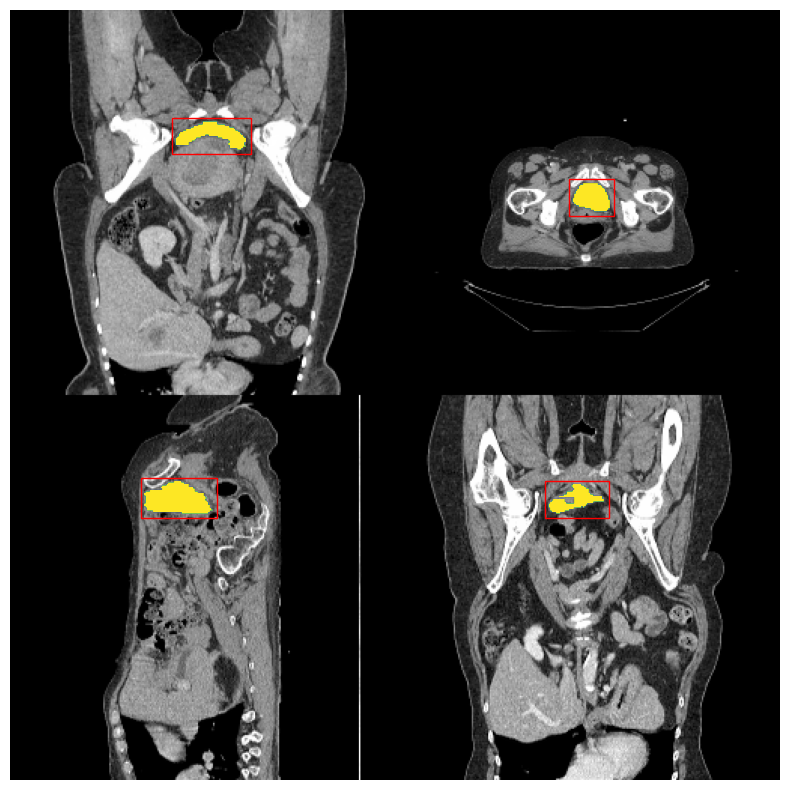

In [22]:
import math

# Get a batch of examples
batch = next(iter(dataloader))

nrows = math.ceil(math.sqrt(batch_size))
images = F.interpolate(batch['image'], size=(256, 256), mode='bilinear', align_corners=False)

grid_imgs = make_grid(images, nrow=nrows, padding=0)
grid_gts = make_grid(batch['gt2D'].float(), nrow=nrows, padding=0)
gts_mask = (grid_gts.sum(dim=0) > 0).float()

plt.figure(figsize=(10, 10))
plt.imshow(grid_imgs.permute(1, 2, 0))
plt.imshow(gts_mask, alpha=gts_mask, cmap='viridis')

shift_x = 0
shift_y = -256
# for i in range(16):

#     shift_y = shift_y + 256 if i % 4 == 0 else shift_y
#     shift_x = shift_x + 256 if i % 4 != 0 else 0

#     coord = batch['coords'][i].squeeze().numpy()
#     for c in coord:
#         x, y = c[0], c[1]
#         x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y
#         plt.scatter(x, y, c='r', s=60)

for i in range(batch_size):

    shift_y = shift_y + 256 if i % nrows == 0 else shift_y
    shift_x = shift_x + 256 if i % nrows != 0 else 0

    coord = batch['boxes'][i, 0].numpy().astype(np.uint16)
    for c in coord:
        x_min, y_min, x_max, y_max = c[0], c[1], c[2], c[3]
        
        # plot the box
        x, y = x_min, y_min
        x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y

        h, w = y_max - y_min, x_max - x_min
        h, w = h * 256 / 1024, w * 256 / 1024

        rectangle = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rectangle)

        # plt.scatter(x, y, c='r', s=60)

plt.axis('off')
plt.show()

## Set up Fine-Tuning nn Module

In [23]:
class MedSAM(nn.Module):
    def __init__(self, 
                image_encoder, 
                mask_decoder,
                prompt_encoder,
                freeze_image_encoder=False,
                ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False
        
        self.freeze_image_encoder = freeze_image_encoder
        if self.freeze_image_encoder:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

    def forward(self, image, point_prompt=None, boxes=None):

        # do not compute gradients for pretrained img encoder and prompt encoder
        with torch.no_grad():
            image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
            # not need to convert box to 1024x1024 grid
            # bbox is already in 1024x1024
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=point_prompt,
                boxes=boxes,
                masks=None,
            )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_masks

In [24]:
sam_model = sam_model_registry["vit_b"](checkpoint=os.path.join(os.environ['PROJECT_DIR'], 'models', 'MedSAM', 'work_dir', 'MedSAM', 'medsam_vit_b.pth'))

medsam_model = MedSAM(
    image_encoder = sam_model.image_encoder,
    mask_decoder = sam_model.mask_decoder,
    prompt_encoder = sam_model.prompt_encoder,
    freeze_image_encoder = True
)
medsam_model = medsam_model.to(device)

checkpoint = torch.load(model_path)

medsam_model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [25]:
# Get data
image = batch["image"].to(device)
gt2D = batch["gt2D"].to(device)
# coords_torch = batch["coords"].squeeze().to(device) # ([B, Ps, 2])
boxes_torch = batch["boxes"].squeeze().to(device) # ([B, Ps, 4])

# self.optimizer.zero_grad()
# labels_torch = torch.ones(coords_torch.shape[0], coords_torch.shape[1]).long() # (B, Ps)
# coords_torch, labels_torch = coords_torch.to(device), labels_torch.to(device)
# point_prompt = (coords_torch, labels_torch)
medsam_lite_pred = medsam_model(image, None, boxes_torch)

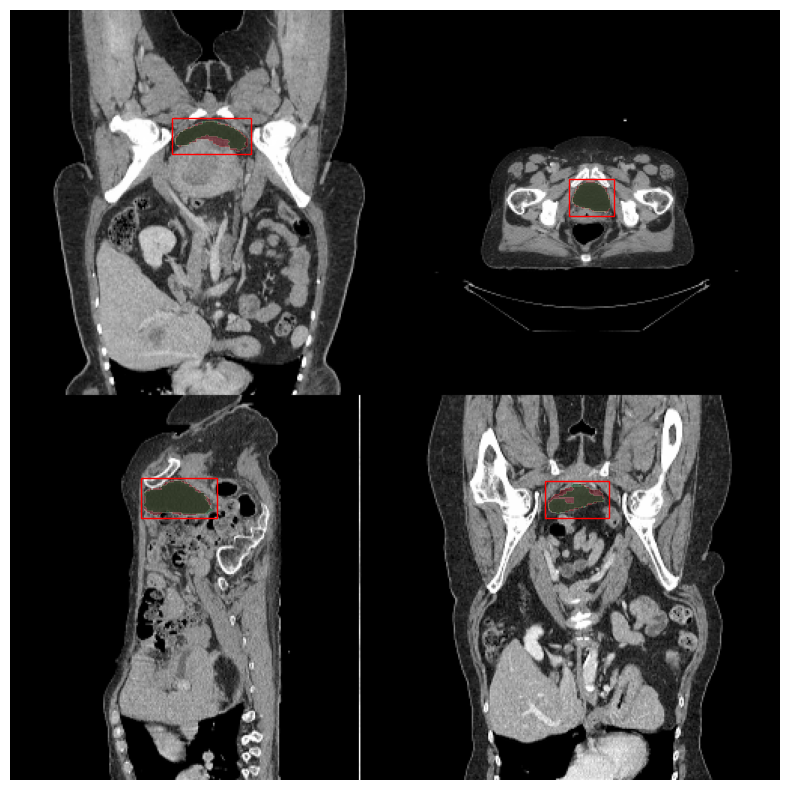

In [26]:
# convert tensor to cpu
image_cpu = image.detach().cpu()
pred_cpu = medsam_lite_pred.detach().cpu()
gt_cpu = gt2D.detach().cpu()

images = F.interpolate(image_cpu, size=(256, 256), mode='bilinear', align_corners=False)

grid_imgs = make_grid(images, nrow=nrows, padding=0)
grid_pred = make_grid(pred_cpu, nrow=nrows, padding=0)
pred_mask = (grid_pred.sum(dim=0) > 0).float() * 0.5

grid_gt = make_grid(gt_cpu, nrow=nrows, padding=0)
gt_mask = (grid_gt.sum(dim=0) > 0).float() * 0.5

plt.figure(figsize=(10, 10))
plt.imshow(grid_imgs.permute(1, 2, 0))
plt.imshow(pred_mask, alpha=pred_mask, cmap='Reds')
plt.imshow(gt_mask, alpha=gt_mask, cmap='Greens')

shift_x = 0
shift_y = -256
# for i in range(16):

#     shift_y = shift_y + 256 if i % 4 == 0 else shift_y
#     shift_x = shift_x + 256 if i % 4 != 0 else 0

#     coord = batch['coords'][i].squeeze().numpy()
#     for c in coord:
#         x, y = c[0], c[1]
#         x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y
#         plt.scatter(x, y, c='r', s=60)

for i in range(batch_size):

    shift_y = shift_y + 256 if i % nrows == 0 else shift_y
    shift_x = shift_x + 256 if i % nrows != 0 else 0

    coord = batch['boxes'][i, 0].numpy().astype(np.uint16)
    for c in coord:
        x_min, y_min, x_max, y_max = c[0], c[1], c[2], c[3]
        
        # plot the box
        x, y = x_min, y_min
        x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y

        h, w = y_max - y_min, x_max - x_min
        h, w = h * 256 / 1024, w * 256 / 1024

        rectangle = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rectangle)

        # plt.scatter(x, y, c='r', s=60)

plt.axis('off')
plt.show()